# analysis of munichs public transportation network (sbahn only)

  * loads vertices and edges from external text files (at the moment there is a bug in the edges:a connection is wrong)
  * it computes an adjacency matrix used to form a graph using networkx
  * the google direction Matrix API and the long/lat information is used to compute distances in [m]

In [4]:
import googlemaps
import json
from datetime import datetime

import networkx as nx

import csv
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# here is my API key from my project
gmaps = googlemaps.Client(key='PUT_GOOGLE_MAPS_API_KEY_HERE')

file_edges = 'edges_sbahn_fixed.txt'
file_verts = 'vertices_stations_fixed.txt'
file_edgesDir = 'edges_withDist.txt'


with open(file_verts, 'rb') as f:
    verts = list(csv.reader(f))
    
with open(file_edges, 'rb') as f:
    edges = list(csv.reader(f))
    
with open(file_edgesDir, 'rb') as f:
    edgesDirs = list(csv.reader(f))
    
def compAdjacencyMat(edges,verts):
    sizeAdj = (len(verts),len(verts))
    adjacencyMat = np.zeros(sizeAdj)
    #adjacencyMat = np.identity(len(verts))
    for ii in range(len(edges)):
        connect = edges[ii]
        adjacencyMat[int(connect[0])-1][int(connect[1])-1] = 1.0
        adjacencyMat[int(connect[1])-1][int(connect[0])-1] = 1.0
        
    return adjacencyMat

#adds a third column of distance in m and a 4th of duration in s
def addDirectionsToEdges(edges,verts):
    sizeEdgesDirs = (len(edges),len(edges[1])+2)
    edges_dirs = np.zeros(sizeEdgesDirs)
    for idx, ed in enumerate(edges):
        #print(str(idx)+'\n')
        current_time = datetime.now()
        #current_time.replace(minute = current_time.minute)
        edges_dirs[int(idx)][0:2] = ed[0:2]
        distance_result = gmaps.distance_matrix(verts[int(ed[0])-1][2]+','+verts[int(ed[0])-1][3],
                                     verts[int(ed[1])-1][2]+','+verts[int(ed[1])-1][3],
                                     mode="transit",transit_mode='rail',traffic_model='best_guess',
                                     departure_time=current_time)
        edges_dirs[int(idx)][2] = distance_result[u'rows'][0][u'elements'][0][u'distance'][u'value']
        edges_dirs[int(idx)][3] = distance_result[u'rows'][0][u'elements'][0][u'duration'][u'value']
    return edges_dirs
    
def writeMatToFile(filename,mat):
    f = open(filename, 'w')
    for edgDist in mat:
        linestr = str(edgDist[0]) + ', ' + str(edgDist[1]) + ', ' + str(edgDist[2]) + ', ' + str(edgDist[3])
        print >> f, linestr
    f.close()

    
def setWeights(G,edgDist):
    for edge in edgDist:
        v1 = int(float(edge[0]))-1
        v2 = int(float(edge[1]))-1
        G[v1][v2]['weight'] = int(float(edge[2]))
    return G

def compDistOfShortPath(G,src,targ):
    shortpath = nx.shortest_path(G,src,targ)
    dist = 0;
    for ii in range(len(shortpath)-1):
        dist = dist + G[shortpath[ii]][shortpath[ii+1]]['weight']
    return dist

def compAllCombination_Dist(G,verts):
    sizeAdj = (len(verts),len(verts))
    distMat = np.zeros(sizeAdj)
    for ii in range(len(verts)):
        for jj in range(len(verts)):
            distMat[ii][jj] = compDistOfShortPath(G,ii,jj)
            
    return distMat

# compute adjacency matrix and form Graph

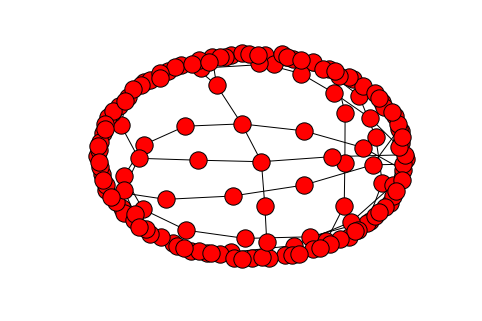

In [5]:
adjMat = compAdjacencyMat(edges,verts)
G = G=nx.from_numpy_matrix(adjMat)
nx.draw(G)

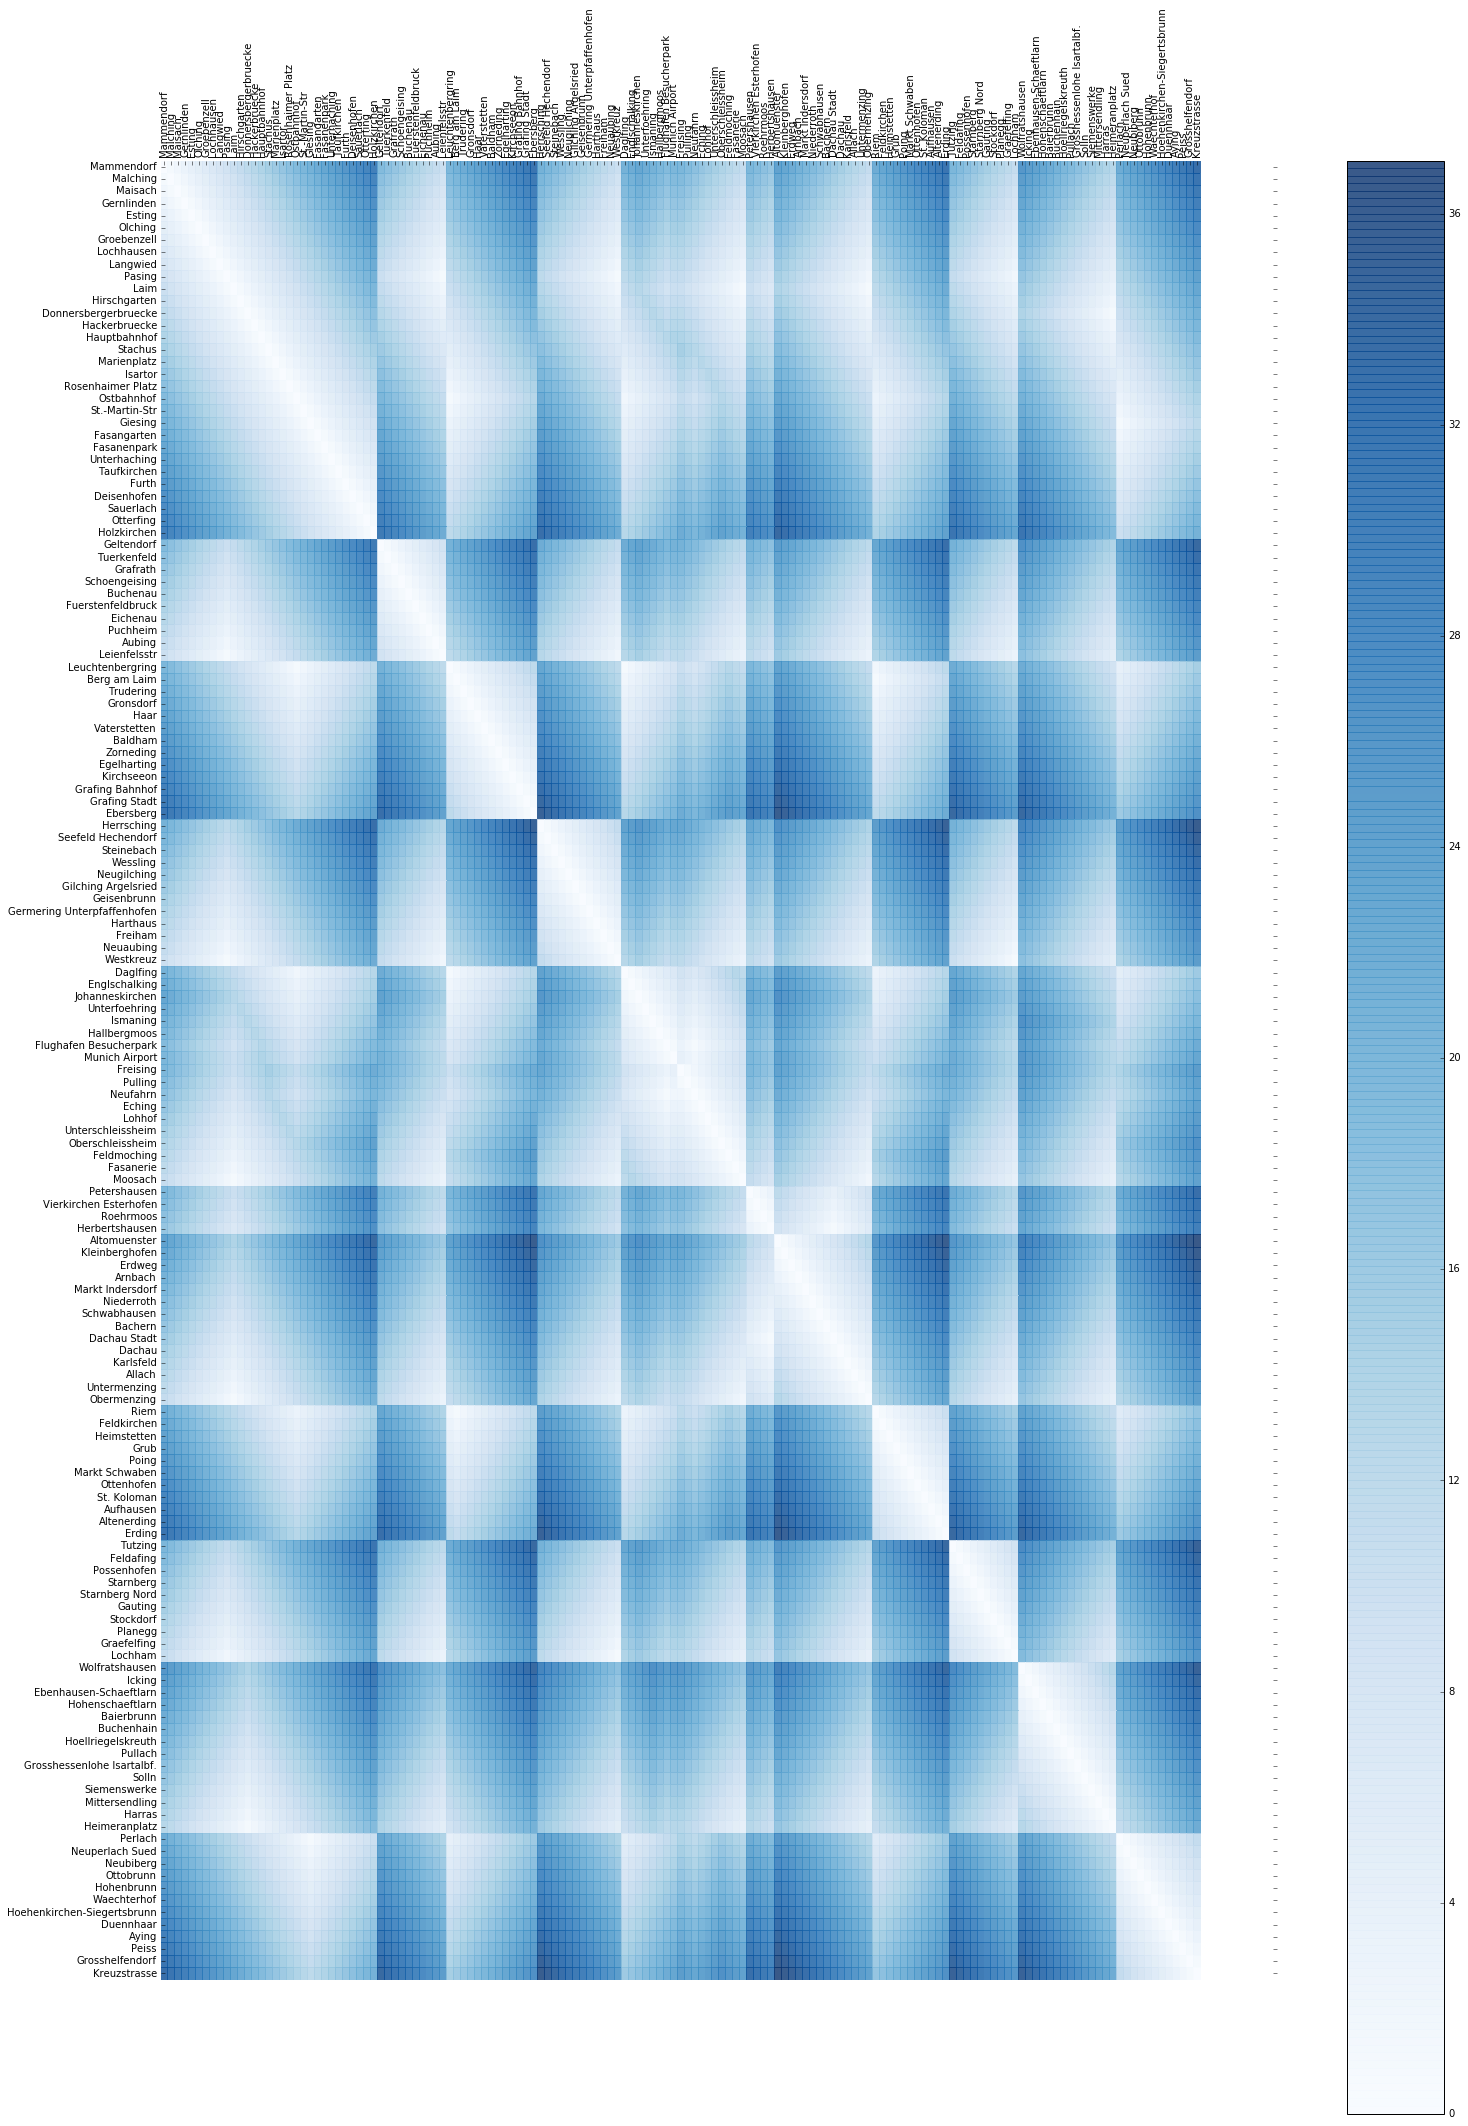

In [6]:
distMat = compAllCombination_Dist(G,verts)

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(distMat, cmap=plt.cm.Blues, alpha=0.8)

# Format
fig = plt.gcf()
fig.set_size_inches(25, 35)

# turn off the frame
ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(149) + 0.5, minor=False)
ax.set_xticks(np.arange(149) + 0.5, minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()

#form labels and put them on axis
labels = [None]*len(verts)
for ii in range(len(verts)):
    labels[ii] = (verts[ii][1])
ax.set_xticklabels(labels, minor=False)
ax.set_yticklabels(labels, minor=False)

# rotate the
plt.xticks(rotation=90)

#ax.grid(False)
#legend
cbar = plt.colorbar(heatmap)
#cbar.ax.set_yticklabels(['0','1','2','>3'])
#cbar.set_label('# of contacts', rotation=270)

# Turn off all the ticks
ax = plt.gca()

# check results by comparing to distance from google distance_matrix

In [8]:
current_time = datetime.now()
distance_res = gmaps.distance_matrix('48.216788, 11.174000',
                                     '48.089545, 11.832342',
                                     mode="transit",transit_mode='rail',traffic_model='best_guess',
                                     departure_time=current_time)
distance_res

{u'destination_addresses': [u'Obere Bahnhofstra\xdfe 46, 85604 Zorneding, Germany'],
 u'origin_addresses': [u'Am Bahnhof 3, 82291 Mammendorf, Germany'],
 u'rows': [{u'elements': [{u'distance': {u'text': u'53.1 km', u'value': 53100},
     u'duration': {u'text': u'1 hour 25 mins', u'value': 5100},
     u'status': u'OK'}]}],
 u'status': u'OK'}